In [80]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

!pip install openpyxl
!pip install pulp

import pulp

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
# reading in all the csv files
file = pd.ExcelFile("/content/drive/MyDrive/ACO/KAGGLE/Supply chain logisitcs problem.xlsx")
plant_ports = file.parse("PlantPorts")
order_list = file.parse("OrderList")
products_plants = file.parse("ProductsPerPlant")
vmi_plants = file.parse("VmiCustomers")
freight_rates = file.parse("FreightRates")
wh_cost = file.parse("WhCosts")
wh_capacities = file.parse("WhCapacities")

In [82]:
# Data cleaning for order_list

# order_list format conversion
order_list['TPT'] = order_list['TPT'].astype(int)
order_list['Ship ahead day count'] = order_list['Ship ahead day count'].astype(int)
order_list['Ship Late Day count'] = order_list['Ship Late Day count'].astype(int)
order_list['Unit quantity'] = order_list['Unit quantity'].astype(int)
order_list['Weight'] = order_list['Weight'].astype(float)
# drop nulls form order_list
order_list.dropna(inplace=True)
# drop duplicates from order_list
order_list.drop_duplicates(inplace=True)

# Data cleaning for freight_rates

# freight_rates format conversion
freight_rates['minm_wgh_qty'] = freight_rates['minm_wgh_qty'].astype(int)
freight_rates['max_wgh_qty'] = freight_rates['max_wgh_qty'].astype(float)
freight_rates['minimum cost'] = freight_rates['minimum cost'].astype(float)
freight_rates['rate'] = freight_rates['rate'].astype(float)
freight_rates['tpt_day_cnt'] = freight_rates['tpt_day_cnt'].astype(int)
# drop nulls form freight_rates
freight_rates.dropna(inplace=True)
# drop duplicates from freight_rates
freight_rates.drop_duplicates(inplace=True)

# Data cleaning for wh_cost

# wh_cost format conversion
wh_cost['Cost/unit'] = wh_cost['Cost/unit'].astype(float)
# drop nulls form wh_cost
wh_cost.dropna(inplace=True)
# drop duplicates from wh_cost
wh_cost.drop_duplicates(inplace=True)

# Data cleaning for wh_capacities

# wh_cost format conversion
wh_capacities['Daily Capacity '] = wh_capacities['Daily Capacity '].astype(int)
# drop nulls form wh_capacities
wh_capacities.dropna(inplace=True)
# drop duplicates from wh_capacities
wh_capacities.drop_duplicates(inplace=True)

# Data cleaning for products_plants

# drop nulls form products_plants
products_plants.dropna(inplace=True)
# drop duplicates from products_plants
products_plants.drop_duplicates(inplace=True)

# Data cleaning for vmi_plants

# drop nulls form vmi_plants
vmi_plants.dropna(inplace=True)
# drop duplicates from vmi_plants
vmi_plants.drop_duplicates(inplace=True)

# Data cleaning for

# drop nulls form plant_ports
plant_ports.dropna(inplace=True)
# drop duplicates from plant_ports
plant_ports.drop_duplicates(inplace=True)

In [83]:
print(order_list.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9215 entries, 0 to 9214
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Order ID              9215 non-null   float64       
 1   Order Date            9215 non-null   datetime64[ns]
 2   Origin Port           9215 non-null   object        
 3   Carrier               9215 non-null   object        
 4   TPT                   9215 non-null   int64         
 5   Service Level         9215 non-null   object        
 6   Ship ahead day count  9215 non-null   int64         
 7   Ship Late Day count   9215 non-null   int64         
 8   Customer              9215 non-null   object        
 9   Product ID            9215 non-null   int64         
 10  Plant Code            9215 non-null   object        
 11  Destination Port      9215 non-null   object        
 12  Unit quantity         9215 non-null   int64         
 13  Weight            

In [84]:
print(freight_rates.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1537 entries, 0 to 1539
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Carrier       1537 non-null   object 
 1   orig_port_cd  1537 non-null   object 
 2   dest_port_cd  1537 non-null   object 
 3   minm_wgh_qty  1537 non-null   int64  
 4   max_wgh_qty   1537 non-null   float64
 5   svc_cd        1537 non-null   object 
 6   minimum cost  1537 non-null   float64
 7   rate          1537 non-null   float64
 8   mode_dsc      1537 non-null   object 
 9   tpt_day_cnt   1537 non-null   int64  
 10  Carrier type  1537 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 144.1+ KB
None


In [85]:
print(wh_cost.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   WH         19 non-null     object 
 1   Cost/unit  19 non-null     float64
dtypes: float64(1), object(1)
memory usage: 456.0+ bytes
None


In [86]:
print(wh_cost.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   WH         19 non-null     object 
 1   Cost/unit  19 non-null     float64
dtypes: float64(1), object(1)
memory usage: 456.0+ bytes
None


In [87]:
print(products_plants.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2036 entries, 0 to 2035
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Plant Code  2036 non-null   object
 1   Product ID  2036 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.7+ KB
None


In [88]:
print(vmi_plants.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Plant Code  14 non-null     object
 1   Customers   14 non-null     object
dtypes: object(2)
memory usage: 336.0+ bytes
None


In [89]:
print(plant_ports.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 0 to 21
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Plant Code  22 non-null     object
 1   Port        22 non-null     object
dtypes: object(2)
memory usage: 528.0+ bytes
None


In [90]:
# changing column names
order_list.columns = [i.replace(" ", "_") for i in order_list.columns]
products_plants.columns = [i.replace(" ", "_") for i in products_plants.columns]
plant_ports.columns = [i.replace(" ", "_") for i in plant_ports.columns]
vmi_plants.columns = [i.replace(" ", "_") for i in vmi_plants.columns]
wh_cost.set_index("WH", inplace=True)

plant_ports_graph = nx.from_pandas_edgelist(plant_ports, source="Plant_Code", target="Port")

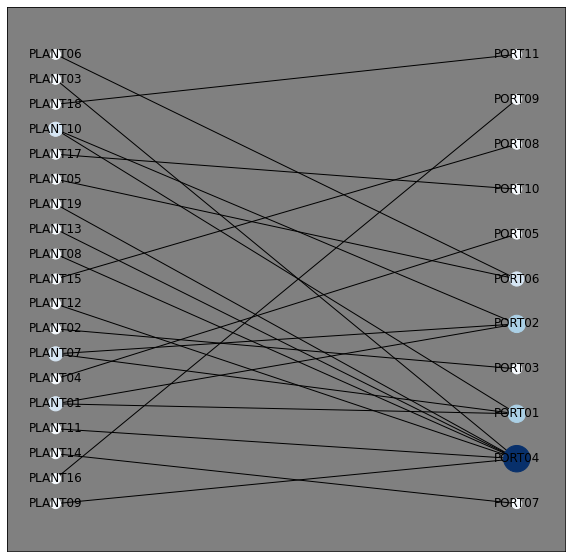

In [91]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_facecolor("Grey")

# specify layout for the graph
# layout = nx.bipartite_layout(plant_ports_graph, plant_ports["Plant Code"])

layout = nx.bipartite_layout(plant_ports_graph, plant_ports["Plant_Code"])

for i in layout:
    if i.startswith("PLANT"):
        layout[i][0] -= 0.1
    else:
        layout[i][0] += 0.1

# we want to map the degree of the node to a color/size
degrees = dict(plant_ports_graph.degree)
maps = [v*100 for v in degrees.values()]

# specify the color map
cmap = plt.cm.Blues

# keyword args that are the same for both functions
kwargs = {"pos":layout, "ax":ax}

nx.draw_networkx_nodes(plant_ports_graph, node_size=maps, node_color=maps, cmap=cmap, **kwargs)
nx.draw_networkx_edges(plant_ports_graph, **kwargs)
nx.draw_networkx_labels(plant_ports_graph, pos=layout)
plt.show()

In [92]:
# get starting and ending points of the edges and add them to the graph
layout = nx.bipartite_layout(plant_ports_graph, plant_ports["Plant_Code"])

edge_x = []
edge_y = []

for edge in plant_ports_graph.edges():
    x0, y0 = layout[edge[0]]
    x1, y1 = layout[edge[1]]
    
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#25488e'),
    hoverinfo='none',
    mode='lines')

# get coordinated of nodes and add them to the graph

node_x = []
node_y = []
for node in plant_ports_graph.nodes():
    x, y = layout[node]
    node_x.append(x)
    node_y.append(y)
    
maps = [v for v in degrees.values()]

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=maps,
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

node_trace.text = [i + " Number of Links: " + str(degrees[i]) for i in degrees]

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Supply Chain',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[dict(text="Factories",
                     showarrow=False,
                     xref="paper", yref="paper",
                     x=0.005, y=-0.002 ),
                             dict(text="Ports",
                     showarrow=False,
                     xref="paper", yref="paper",
                     x=0.95, y=-0.002 )],
                xaxis=dict(showgrid=True, zeroline=False, showticklabels=True),
                yaxis=dict(showgrid=True, zeroline=False, showticklabels=True))
                )
fig

## Most facilities have only one connection to a port. Port 4 is potentially the most important one as it has the most connections to the warehouses.

Preparing the Order Table
The existing order table already contains a solution. We will delete those columns.

In [93]:
order_new = order_list.drop(columns=["Order_Date", "Origin_Port", "Carrier", "Plant_Code", "TPT", "Service_Level", "Ship_ahead_day_count", "Ship_Late_Day_count"])
order_new.set_index("Order_ID", inplace=True)
order_new.to_csv("order_new.csv")

Preparing Freight Table

In [94]:
freight_rates.drop(columns=["dest_port_cd", "Carrier type", "svc_cd"], inplace=True)
freight_rates.to_csv("FreightRates_mod.csv")

Problem Restrictions

In [95]:
# given a product id, return the plants that can produce this product.
def product_restriction(index):
    data = order_new.loc[index]
    product_id = data["Product_ID"]
    possible_plants = products_plants.loc[products_plants["Product_ID"] == product_id]
    return np.array(possible_plants["Plant_Code"])

# vmi restriction: check if a given customer has to be serviced by a specific facility, else return all facilities as possibilities.
def customer_restriction(index):
    data = order_new.loc[index]
    Customer_id = data["Customer"]
    possible_plants = vmi_plants.loc[vmi_plants["Customers"] == Customer_id]
    if list(possible_plants["Plant_Code"]) == []:
        return plant_ports["Plant_Code"].unique()
    else:
        return np.array(possible_plants["Plant_Code"])

# combine both the product and vmi restriction. There will be orders for which only one, or possibly even 0, facilities can fullfil it.
def check_order(Order_Id, length=True):
    if length:
        return len(np.intersect1d(customer_restriction(Order_Id), product_restriction(Order_Id)))
    else:
        return np.intersect1d(customer_restriction(Order_Id), product_restriction(Order_Id))

# under the restrictions above, we can calculate the number of facilities that can process a given order.
order_new["decision_space_size"] = np.array(list(map(check_order, order_new.index)))

In [96]:
order_new["decision_space_size"].value_counts()

1    6275
0    1045
4     982
2     785
3     127
5       1
Name: decision_space_size, dtype: int64

We can see that for most orders, there is only one facility that can handle the order. For ~1,000 there is no possible facility that can handle the order given our problem restrictions, we will exclude these orders from our further optimization problem.

# Assigning orders

Instead of using the specific rate for a carrier we will aggregate the rates for a given port. The main problem is that rates range from 0.03 to 128 which makes it hard to know the unit of measurement (e.g. €/kg or €/unit). Therefore I will average the rates for each port and use those as the costs.

In [97]:
freight_rates["rate"].describe()

count    1537.000000
mean        2.875135
std         4.590475
min         0.033200
25%         0.451200
50%         1.656800
75%         3.916800
max       128.027200
Name: rate, dtype: float64

In [98]:
ports_agg = freight_rates.groupby(["orig_port_cd"]).agg(avg_rate=("rate", np.mean))
# we will exclude orders that cannot be processed by any facility (i.e. where the decision space size == 0)
order_new = order_new.loc[order_new.decision_space_size != 0]
# return the possible plants that can process the order.
order_new["decision_space_plants"] = np.array((map(lambda x: check_order(x, length=False), order_new.index)))

def min_cost(dec_space):
    
    plant_port_cost = {}
    
    wh = wh_cost.copy()
    min_cost = np.inf
    
    for plant in dec_space:
        plant_port_cost[plant] = wh.loc[plant].iloc[0]
        port_price, port = find_best_port(plant)
        plant_port_cost[plant] += port_price
        
        if plant_port_cost[plant] < min_cost:
            min_cost = plant_port_cost[plant]
            best_plant = plant
            best_port = port
            best_port_price = port_price
        
    return min_cost, best_plant, best_port_price, best_port

# given a port and the order specifications return the carrier that can handle the product at the best price.
def find_best_port(plant_id):
    # choose the ports that have a connection to the given plant and then find the port with the lowest freight rate
    possible_ports = plant_ports.loc[(plant_ports.Plant_Code == plant_id) & (plant_ports.Port != "PORT01"), "Port"]
    possible_ports = ports_agg.loc[possible_ports]
    return possible_ports.loc[possible_ports["avg_rate"] == min(possible_ports["avg_rate"])].iloc[0]["avg_rate"], possible_ports.loc[possible_ports["avg_rate"] == min(possible_ports["avg_rate"])].iloc[0].name

order_new["decision"] = order_new["decision_space_plants"].apply(min_cost)

In [99]:
order_new["decision"]

Order_ID
1.447296e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447158e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447139e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447364e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
1.447364e+09    (4.7563741745191, PLANT16, 2.8365666666666662,...
                                      ...                        
1.447372e+09        (10.321903518927222, PLANT02, 9.8444, PORT03)
1.447372e+09        (10.321903518927222, PLANT02, 9.8444, PORT03)
1.447328e+09        (10.321903518927222, PLANT02, 9.8444, PORT03)
1.447358e+09        (10.321903518927222, PLANT02, 9.8444, PORT03)
1.447287e+09        (10.321903518927222, PLANT02, 9.8444, PORT03)
Name: decision, Length: 8170, dtype: object

In [100]:
decision = order_new["decision"].tolist()
lenn = len(decision)
min_cost_list = []
for i in range(lenn):
  min_cost_list.append(decision[i][0])
best_plant_list = []
for i in range(lenn):
  best_plant_list.append(decision[i][1])
best_port_price_list = []
for i in range(lenn):
  best_port_price_list.append(decision[i][2])
best_port_list = []
for i in range(lenn):
  best_port_list.append(decision[i][3])

decision_dataframe = pd.DataFrame(
    {'min_cost': min_cost_list,
     'best_plant': best_plant_list,
     'best_port_price': best_port_price_list,
     'best_port': best_port_list,
    })

In [101]:
decision_dataframe

,min_cost,best_plant,best_port_price,best_port
0,4.756374,PLANT16,2.836567,PORT09
1,4.756374,PLANT16,2.836567,PORT09
2,4.756374,PLANT16,2.836567,PORT09
3,4.756374,PLANT16,2.836567,PORT09
4,4.756374,PLANT16,2.836567,PORT09
...,...,...,...,...
8165,10.321904,PLANT02,9.844400,PORT03
8166,10.321904,PLANT02,9.844400,PORT03
8167,10.321904,PLANT02,9.844400,PORT03
8168,10.321904,PLANT02,9.844400,PORT03


In [102]:
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/MyDrive/ACO/KAGGLE/decision.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  decision_dataframe.to_csv('decision.csv', sep='\t', encoding='utf-8')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


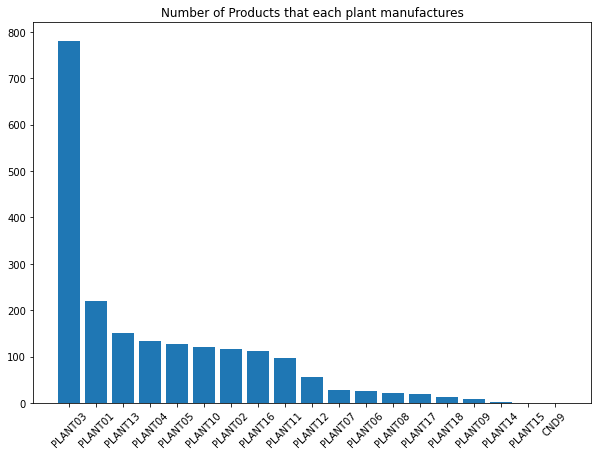

In [103]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
plt.xticks(rotation=45)
plant_counts = pd.DataFrame(products_plants["Plant_Code"].value_counts())
ax.bar(plant_counts.index, plant_counts["Plant_Code"])
plt.title("Number of Products that each plant manufactures")
plt.show()

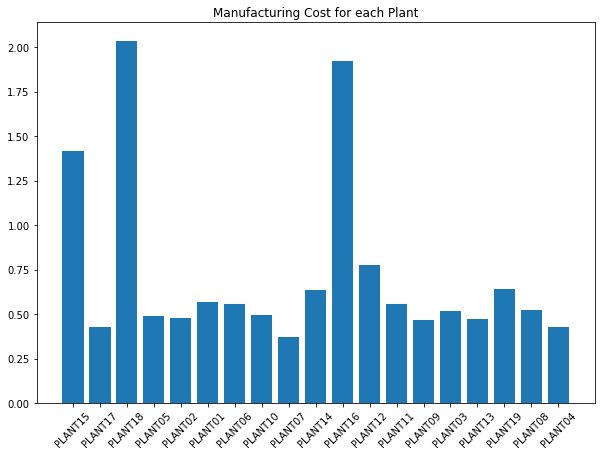

In [104]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
plt.xticks(rotation=45)
ax.bar(wh_cost.index, wh_cost["Cost/unit"])
plt.title("Manufacturing Cost for each Plant")
plt.show()